# <b> <div style='padding:25px;background-color:#9B2335;color:white;border-radius:4px;font-size:100%;text-align: center'>Singapore  Resale Flat Prices Prediction<br> </div>

## <p style="color:Khaki;"> Importing required libraries</p>

In [19]:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle

sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color


In [20]:
df1=pd.read_feather('df1.feather')

In [21]:
df1.sample(5)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year
177380,12,Pasir Ris,Executive,149.0000,Maisonette,1992,628000.0000,3,6,1997,537 Pasir Ris St 51 Pasir Ris,4214.7651,94
236727,6,Punggol,5 Room,110.0000,Improved,2003,307200.0000,3,15,2007,107D Edgefield Plains Punggol,2792.7273,95
16448,10,Sengkang,5 Room,110.0000,Improved,2001,430000.0000,3,12,2017,305B Anchorvale Link Sengkang,3909.0909,83
19435,8,Ang Mo Kio,3 Room,82.0000,New Generation,1979,47000.0000,3,9,1991,570 Ang Mo Kio Ave 3 Ang Mo Kio,573.1707,87
42219,1,Bedok,5 Room,127.0000,Improved,1993,620000.0000,3,15,2019,94E Bedok Nth Ave 4 Bedok,4881.8898,73


## <p Style="color: Khaki"> Data Transformation:

### <p Style="color: Khaki">Experimenting with a few types of data transformation techniques to see which one suits best.

#### <p Style="color: Aqua"> Defining a function to perform Box-Cox and Applying

In [22]:
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x)
    return transformed_data,lmbda

In [23]:
method_functions =  {
    'log': np.log,
    'square': np.sqrt,
    'rec': lambda x: 1 / x,
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'pow': lambda x: np.power(x, 2),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method):
    normalized_df=pd.DataFrame()

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name in ['boxcox']:
                transformed_values = func(df[col])[0]
            else:
                transformed_values = func(df[col])
            normalized_df[new_column] = transformed_values

    return normalized_df

#### <p Style="color: Aqua"> Created a new Data Frame that contains transformed values:

In [24]:
normalized_df=skewness_checker(df1, ['floor_area_sqm','resale_price'], method_functions)
normalized_df.sample(5)

,floor_area_sqm_log,resale_price_log,floor_area_sqm_square,resale_price_square,floor_area_sqm_rec,resale_price_rec,floor_area_sqm_sig,resale_price_sig,floor_area_sqm_pow,resale_price_pow,floor_area_sqm_exp,resale_price_exp,floor_area_sqm_boxcox,resale_price_boxcox
90700,4.2195,11.7932,8.2462,363.7994,0.0147,0.0000,1.0000,1.0000,4624.0000,17516522500.0000,2.3254,10.5766,9.5564,399.6817
20,4.4067,11.0021,9.0554,244.9490,0.0122,0.0000,1.0000,1.0000,6724.0000,3600000000.0000,2.4141,9.0288,10.3895,281.8420
18576,4.7622,11.8636,10.8167,376.8289,0.0085,0.0000,1.0000,1.0000,13689.0000,20164000000.0000,2.5920,10.7265,12.1278,412.2818
148232,4.2047,12.9239,8.1854,640.3124,0.0149,0.0000,1.0000,1.0000,4489.0000,168100000000.0000,2.3185,13.2604,9.4927,657.7256
149706,4.4998,13.7375,9.4868,961.7692,0.0111,0.0000,1.0000,1.0000,8100.0000,855625000000.0000,2.4595,15.6037,10.8243,940.7357


#### <p Style="color: Aqua"> Plotting all type of transformed values:

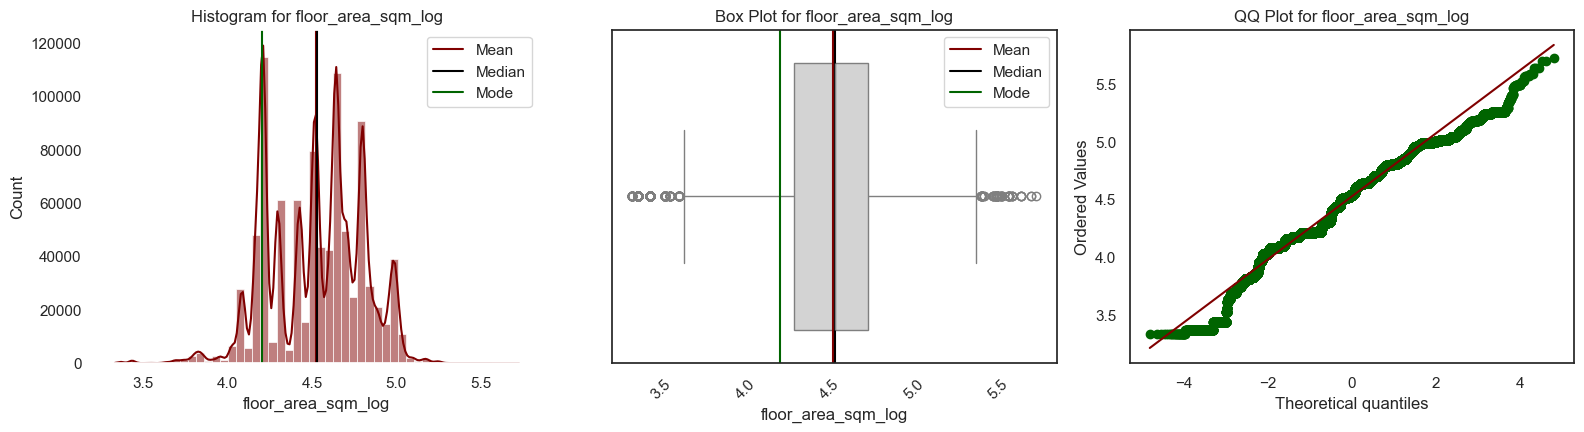



Skew for floor_area_sqm_log is -0.23

Kurtosis for floor_area_sqm_log is -0.36




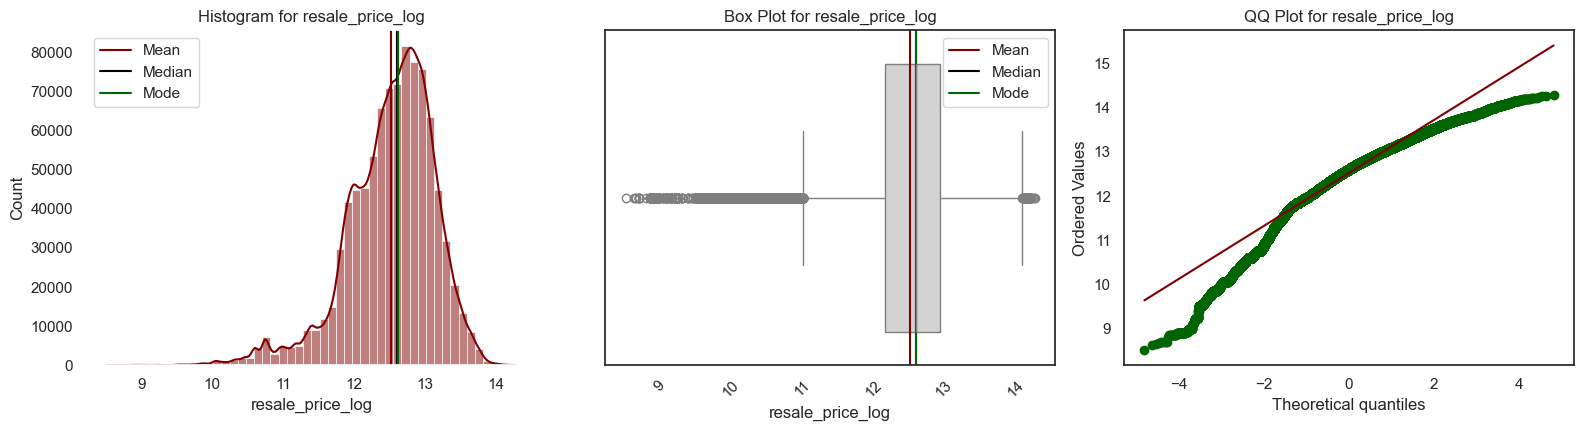



Skew for resale_price_log is -0.92

Kurtosis for resale_price_log is 1.61




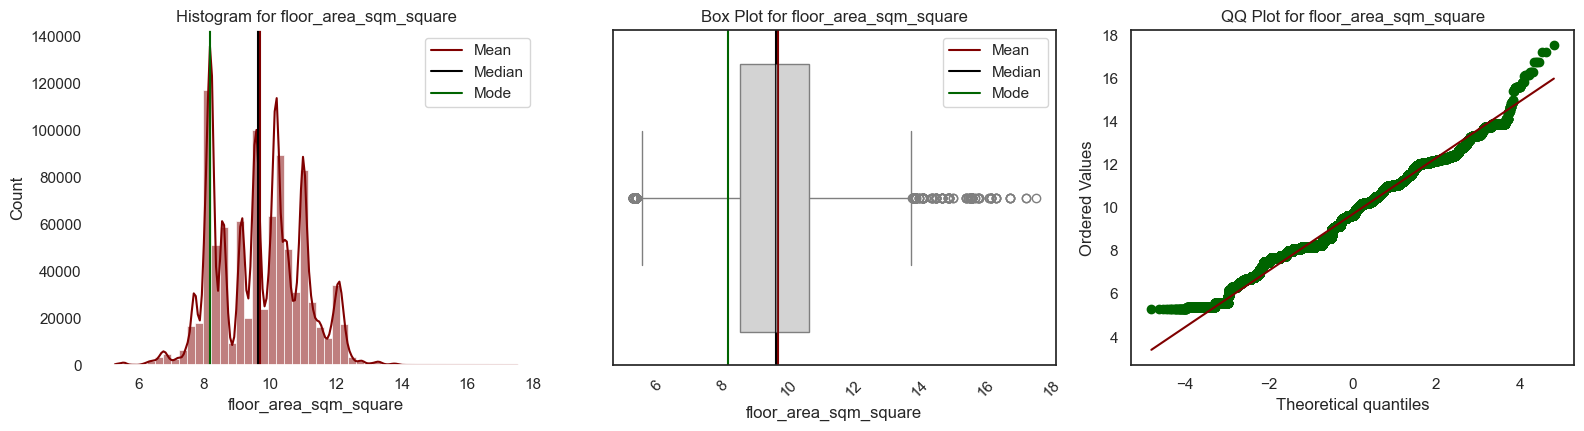



Skew for floor_area_sqm_square is 0.08

Kurtosis for floor_area_sqm_square is -0.57




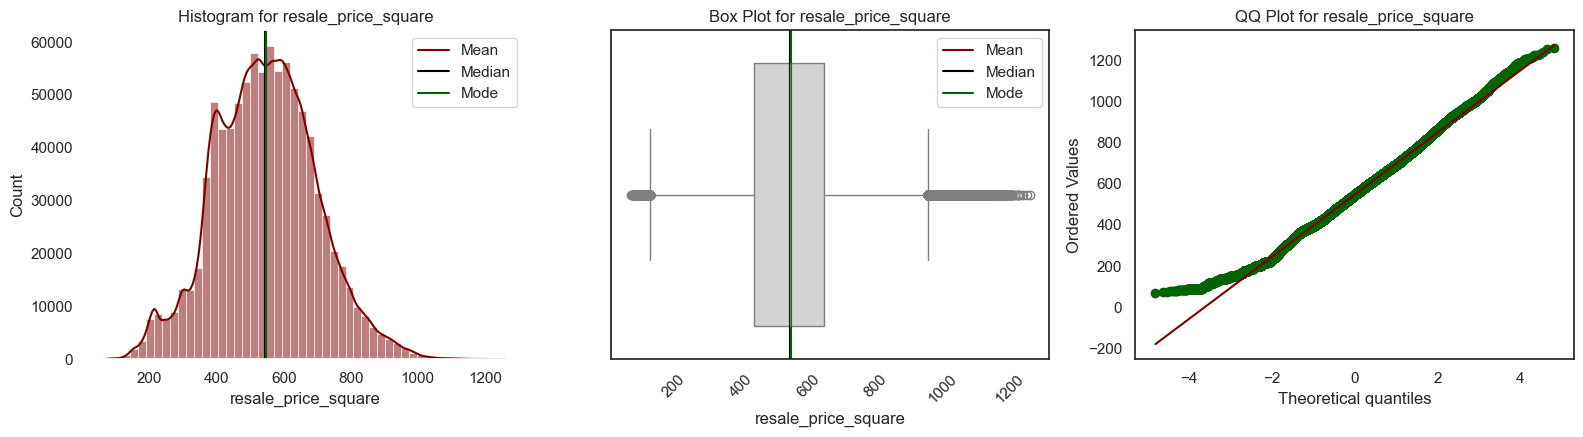



Skew for resale_price_square is 0.11

Kurtosis for resale_price_square is 0.05




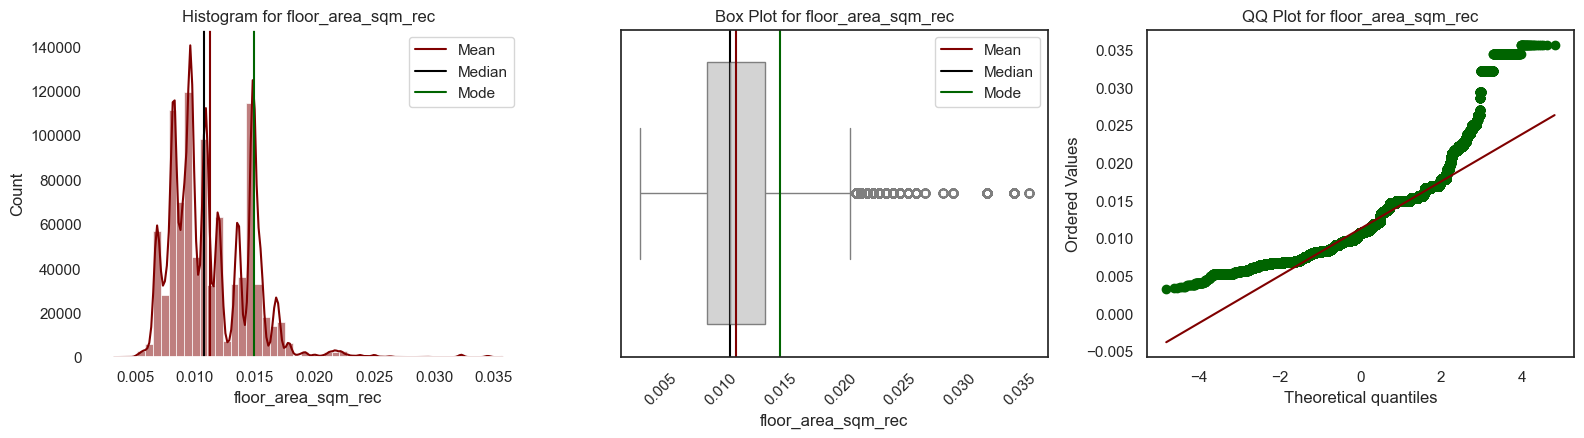



Skew for floor_area_sqm_rec is 1.10

Kurtosis for floor_area_sqm_rec is 3.00




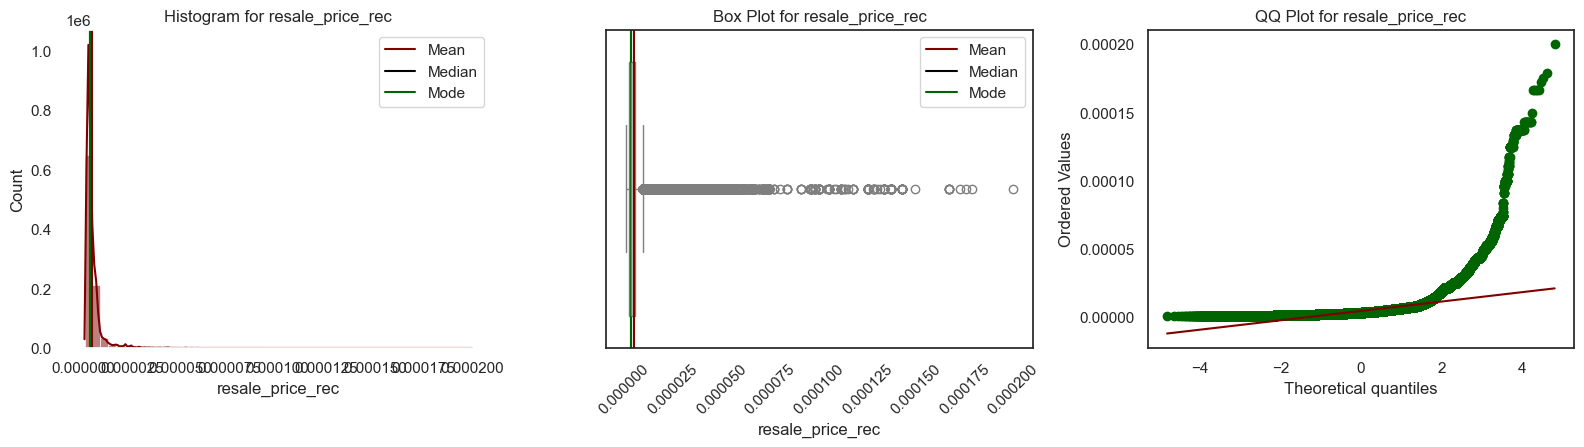



Skew for resale_price_rec is 7.24

Kurtosis for resale_price_rec is 112.40




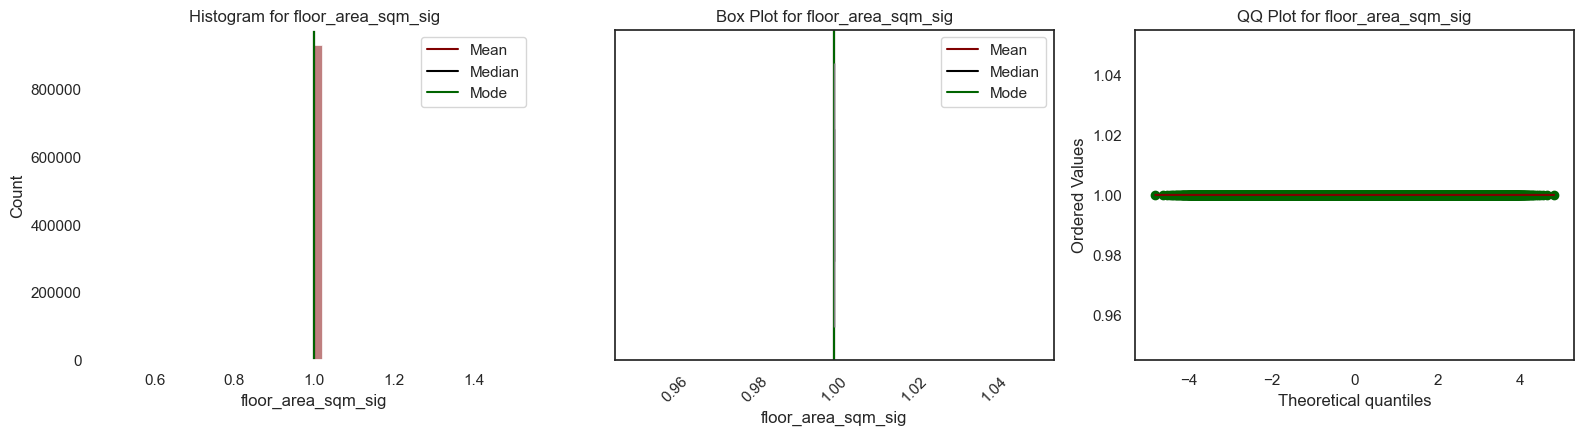



Skew for floor_area_sqm_sig is 0.00

Kurtosis for floor_area_sqm_sig is 0.00




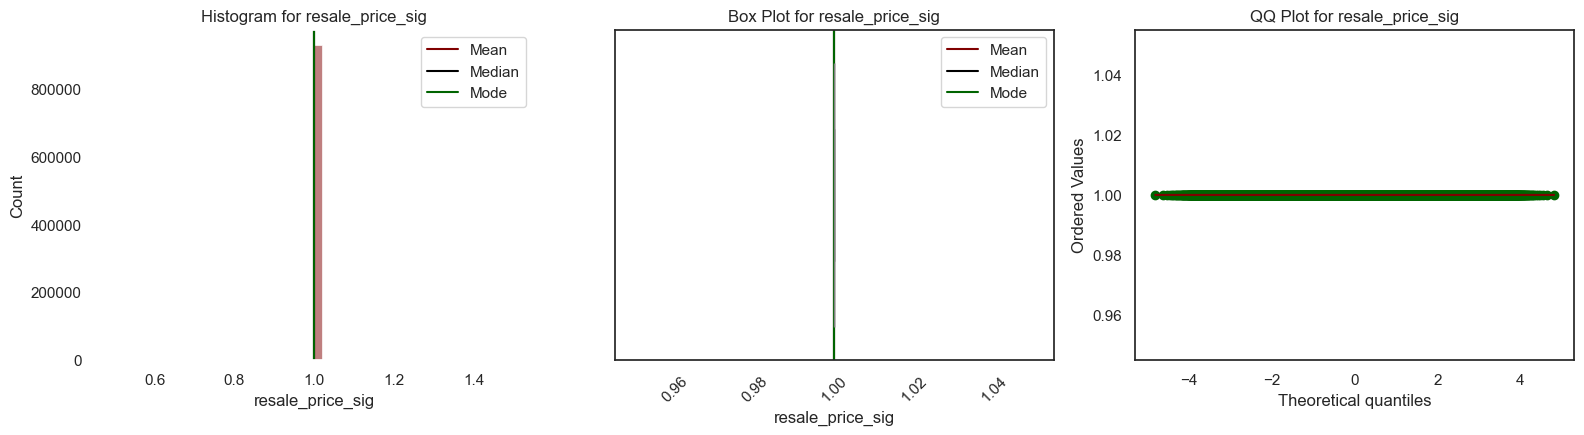



Skew for resale_price_sig is 0.00

Kurtosis for resale_price_sig is 0.00




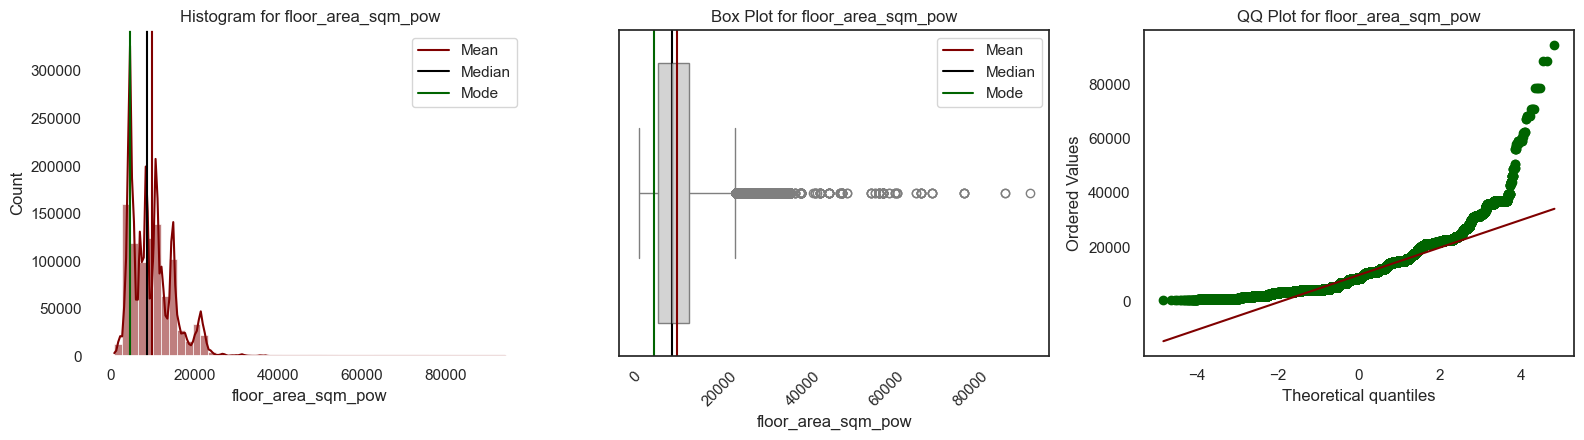



Skew for floor_area_sqm_pow is 1.00

Kurtosis for floor_area_sqm_pow is 1.66




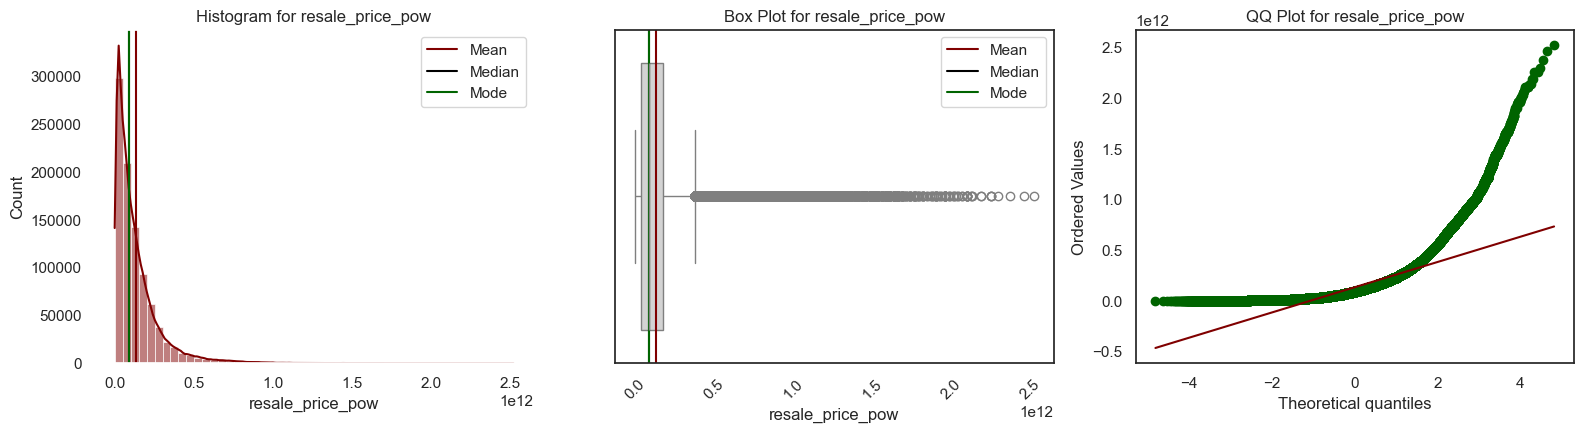



Skew for resale_price_pow is 2.81

Kurtosis for resale_price_pow is 13.23




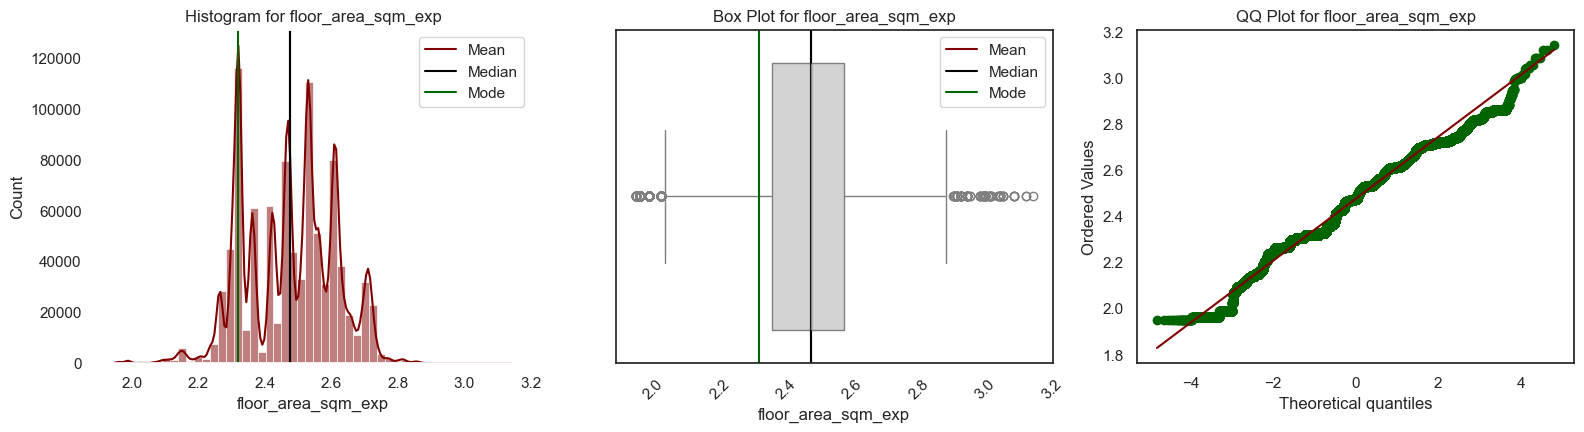



Skew for floor_area_sqm_exp is -0.11

Kurtosis for floor_area_sqm_exp is -0.50




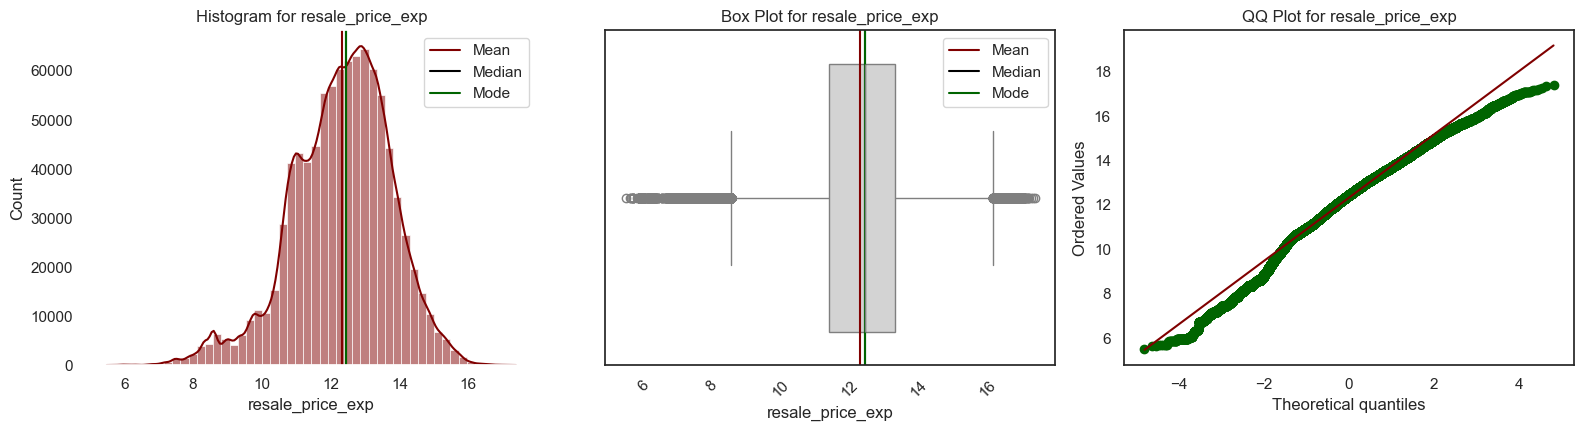



Skew for resale_price_exp is -0.46

Kurtosis for resale_price_exp is 0.48




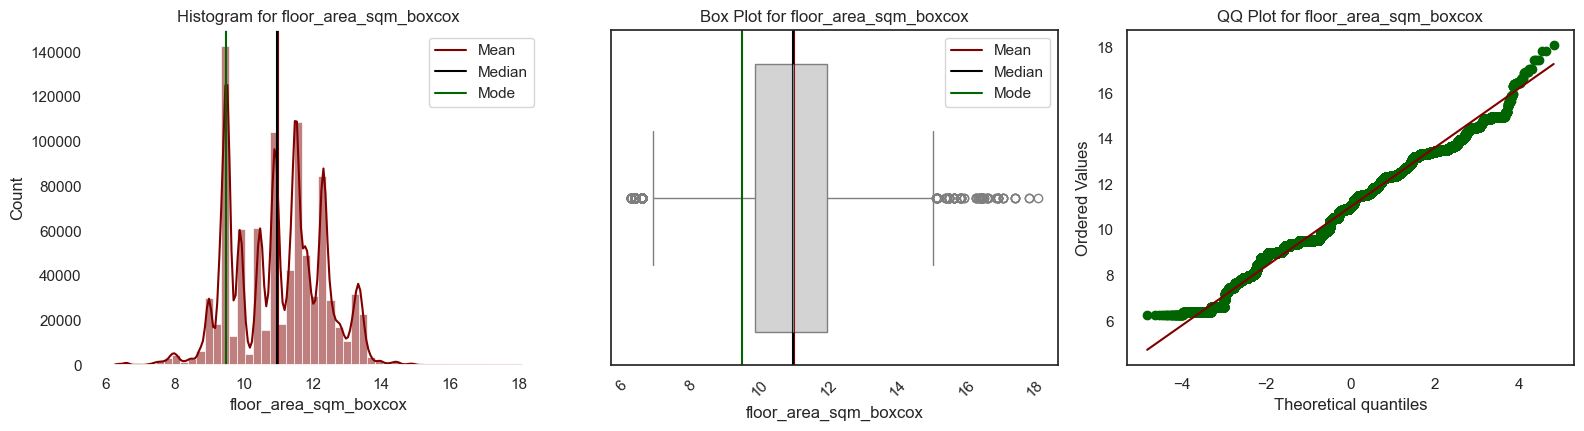



Skew for floor_area_sqm_boxcox is -0.02

Kurtosis for floor_area_sqm_boxcox is -0.55




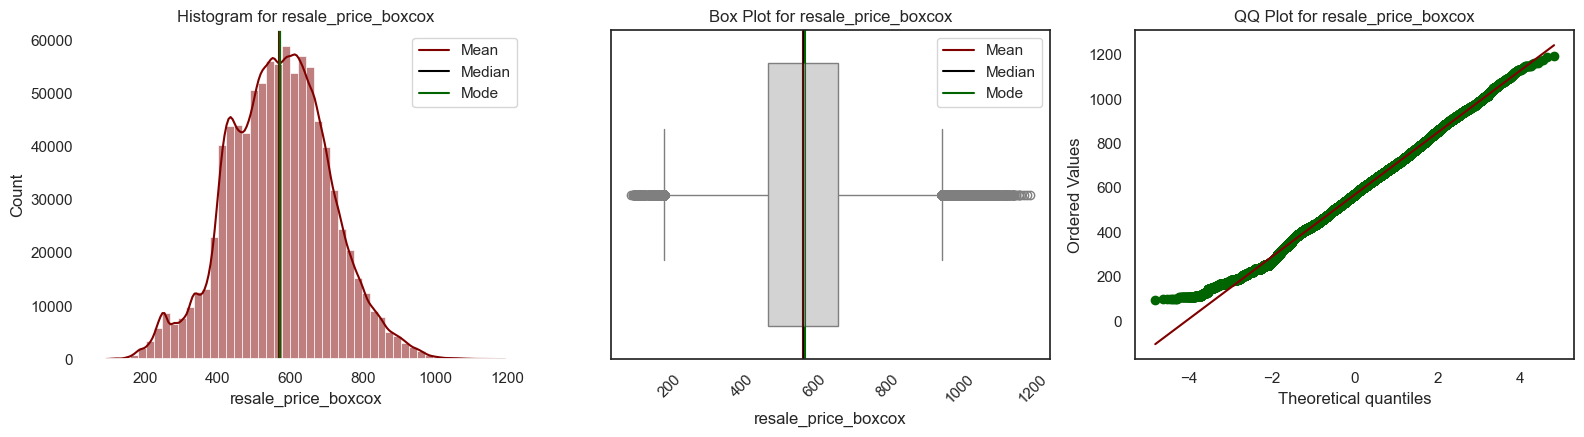



Skew for resale_price_boxcox is -0.00

Kurtosis for resale_price_boxcox is 0.05


Skewness:
 {'floor_area_sqm_log': -0.23334388, 'resale_price_log': -0.9240431018462136, 'floor_area_sqm_square': 0.07508402, 'resale_price_square': 0.10918464819090822, 'floor_area_sqm_rec': 1.1036736, 'resale_price_rec': 7.24332894254145, 'floor_area_sqm_sig': 0.0, 'resale_price_sig': 0.0, 'floor_area_sqm_pow': 1.0026332, 'resale_price_pow': 2.810519042318628, 'floor_area_sqm_exp': -0.10569635, 'resale_price_exp': -0.4641821320745675, 'floor_area_sqm_boxcox': -0.016471082, 'resale_price_boxcox': -0.0005540558944127643} 

 Kurtois:
 {'floor_area_sqm_log': -0.35770032, 'resale_price_log': 1.6050165886358765, 'floor_area_sqm_square': -0.56573135, 'resale_price_square': 0.04932580507928508, 'floor_area_sqm_rec': 3.003057, 'resale_price_rec': 112.3990151551124, 'floor_area_sqm_sig': 0.0, 'resale_price_sig': 0.0, 'floor_area_sqm_pow': 1.6554761, 'resale_price_pow': 13.227158328215623, 'floor_area_sqm_exp': -

In [25]:
transformed_skewness = {}
transformed_kurtosis = {}
for i in normalized_df.columns:
    univar_num(normalized_df,i)
    skews=normalized_df[i].skew()
    kurt=normalized_df[i].kurtosis()
    transformed_skewness.update({i:skews})
    transformed_kurtosis.update({i:kurt})
    color = color_neutral
    if -0.5 <= skews <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skews <= 0.5 or -0.5 < skews < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
      
    print(f"\n\n{color}Skew for {i} is {skews:.2f}{color_neutral}")    
    print(f"\n{color}Kurtosis for {i} is {kurt:.2f}{color_neutral}\n\n")
print( 'Skewness:\n',transformed_skewness,'\n\n','Kurtois:\n',transformed_kurtosis)


<span style="color: Chartreuse;font-size:150%">   &#9784; </span> <span style="color: Tomato;font-size: 120%;background-color:"> <b> Based on the skewness and kurtosis values, the <span Style="color:Aqua"> Box-Cox transformation </span>is the best choice for addressing outliers and normalizing the distributions of both floor_area_sqm and resale_price. This should improve the performance of your predictive models.</b></span>

### <p Style="color: Khaki"> Applying Box-Cox transformation to our data and pickling:

In [26]:
lambda_dict = {}

df1['resale_price_boxcox'] , lambda_dict['resale_price_lambda'] = boxcox_transform(df1['resale_price'] +1)
df1['floor_area_boxcox'] , lambda_dict['floor_area_lambda'] = boxcox_transform(df1['floor_area_sqm'] +1)

os.makedirs('pkls', exist_ok=True)

with open(r'pkls/boxcox_lambdas.pkl', 'wb') as f:
    pickle.dump(lambda_dict, f)

In [27]:
df1.sample(6)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox
142326,2,Queenstown,2 Room,42.0000,Standard,1970,95000.0000,3,9,2004,29 Tanglin Halt Rd Queenstown,2261.9048,65,345.2727,7.6096
67376,11,Bukit Panjang,3 Room,73.0000,Model A,1988,130000.0000,3,12,2001,123 Pending Rd Bukit Panjang,1780.8219,86,396.5256,9.7438
82736,4,Bukit Merah,3 Room,59.0000,Standard,1971,126000.0000,3,6,2002,24 Beo Cres Bukit Merah,2135.5932,68,391.0968,8.8725
185192,3,Bedok,5 Room,125.0000,Standard,1978,372000.0000,3,21,1998,98 Bedok Nth Ave 4 Bedok,2976.0000,79,630.1446,12.2545
17061,5,Queenstown,5 Room,117.0000,Standard,1977,161000.0000,3,21,1991,8 Ghim Moh Rd Queenstown,1376.0684,85,435.7421,11.9200
213655,8,Bishan,4 Room,107.0000,Model A,1992,286000.0000,3,6,2006,210 Bishan St 23 Bishan,2672.8972,85,561.2732,11.4801


In [28]:
df1.to_feather('data_trans.feather')